### Core

In [1]:
# header
import torch
from torch import nn
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from typing import Tuple, Dict, List
from torchinfo import summary
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from pathlib import Path
import random
from PIL import Image
from timeit import default_timer as timer
from tqdm.auto import tqdm
device = "cuda" if torch.cuda.is_available() else "cpu"
image_path = Path("data") / "pizza_steak_sushi"


In [2]:
# functions
def tensorprint(tensor):
    print("Shape: " , tensor.shape, " , Dimension: ", tensor.ndim , " \nDtype: ", tensor.dtype, " , Device: ", tensor.device)
    print("Max: ", tensor.amax(),f'[{tensor.argmax()}]', " , Min: ", tensor.amin(),f'[{tensor.argmin()}]')
    #print(tensor ,'\n')

def torch_rng():
    torch.manual_seed(42)
    torch.cuda.manual_seed(42)

def accuracy_fn(y_true,y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct/len(y_pred)) * 100
    return acc

def print_time(start,end,device = None):
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

def walk_through_dir(dir_path):
    """Walks Through dir_path returning its contents."""
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"directories: {len(dirnames)} | images: {len(filenames)} -> {dirpath}")

def plot_transformed_images(image_path: list, transforms, n=3, seed=42):
    """Select random image from image_path to transform and plot the orig & transformed"""
    random.seed(seed)
    random_image_path = random.sample(image_path, k=n)
    for i in random_image_path:
        with Image.open(i) as f:
            fig, ax = plt.subplots(nrows = 1,ncols =2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original Size:\n{f.size}")
            ax[0].axis(False)

            transformed_image = transforms(f).permute(1,2,0)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed Shape:\n{transformed_image.shape}")
            ax[1].axis(False)

            fig.suptitle(f"Class: {i.parent.stem}", fontsize = 16)

def find_classes(directory: str) -> Tuple[List[str] , dict[str,int]]:
    """Finds class folder names in target directory."""
    class_names_found = sorted([entry.name for entry in list(os.scandir(directory)) if entry.is_dir()])
    if not class_names_found:
        raise FileNotFoundError(f"Couldn't find any classes: {directory}")
    class_to_idx = {class_name: i for i , class_name in enumerate(class_names_found)}

    return class_names_found, class_to_idx

def display_random_images(dataset:torch.utils.data.Dataset,
                        classes: List[str] = None,
                        n: int =10,
                        display_shape: bool = True,
                        seed: int = None):
    if n > 10:
        n = 10
        display_shape = False

    if seed:
        random.seed(seed)

    random_samples_idx = random.sample(range(len(dataset)), k =n)
    plt.figure(figsize=(16,8))

    for i , tar_sample in enumerate(random_samples_idx):
        targ_image , targ_label = dataset[tar_sample][0], dataset[tar_sample][1]
        tar_image_adjust = targ_image.permute(1,2,0) # [CHW] -> [HWC]
        plt.subplot(1,n,i+1)
        plt.imshow(tar_image_adjust)
        plt.axis(False)
        if classes:
            title = f"Class: {classes[targ_label]}"
            if display_shape:
                title = title + f"\nshape: {tar_image_adjust.shape}"
        plt.title(title)

def train_step(model: torch.nn.Module,
                dataloader:torch.utils.data.DataLoader,
                loss_fn:torch.nn.Module,
                optimizer:torch.optim.Optimizer,
                accuracy_fn = accuracy_fn,
                device: torch.device = device):
    """Performs training on dataloader."""
    train_loss, train_acc = 0,0
    model.train()
    for X,y in dataloader:
        
        X, y = X.to(device), y.to(device)
        
        y_pred = model(X)

        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        train_acc += accuracy_fn(y, y_pred.argmax(dim=1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= len(dataloader)
    train_acc /= len(dataloader)
    print(f"\nTrain loss: {train_loss:.4f} | Train acc: {train_acc:.2f}")
    return train_loss, train_acc

def test_step(model: torch.nn.Module,
                dataloader:torch.utils.data.DataLoader,
                loss_fn:torch.nn.Module,
                accuracy_fn = accuracy_fn,
                device: torch.device = device):
    """Performs testing on dataloader."""
    test_loss, test_acc = 0,0
    model.eval()

    with torch.inference_mode():
        for X,y in dataloader:
            X, y = X.to(device), y.to(device)
            test_pred = model(X)
            test_loss += loss_fn(test_pred,y).item()
            test_acc += accuracy_fn(y,test_pred.argmax(dim=1))

        test_loss /= len(dataloader)
        test_acc /= len(dataloader)
    #print(f"\nTest loss: {test_loss:.4f} | Test acc: {test_acc:.2f}")
    return test_loss, test_acc

def train(model: torch.nn.Module,
            train_dataloader:torch.utils.data.DataLoader,
            test_dataloader:torch.utils.data.DataLoader,
            optimizer:torch.optim.Optimizer,
            loss_fn:torch.nn.Module = nn.CrossEntropyLoss(),
            epochs: int = 5,
            device = device):
    """Combines train_step and test_step function"""
    results = {"train_loss" : [],
                "train_acc" : [],
                "test_loss" : [],
                "test_acc"  : []}
    for epoch in tqdm(range(epochs)):
        train_loss , train_acc = train_step(model,
                                            dataloader=train_dataloader,
                                            loss_fn=loss_fn,
                                            optimizer=optimizer,
                                            device=device)
        test_loss , test_acc = test_step    (model,
                                            dataloader=test_dataloader,
                                            loss_fn=loss_fn,
                                            device=device)
        print(f"Epoch: {epoch} | Train acc: {train_acc:.2f} | Test loss: {test_loss:.4f} | Test acc: {test_acc:.2f}")
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
    
    return results

def plot_loss_curves(results: Dict[str, List[float]]):
    """Plots training curves of result dictionary."""
    loss = results["train_loss"]
    test_loss = results["test_loss"]
    acc = results["train_acc"]
    test_acc = results["test_acc"]
    epochs = range(len(results["train_loss"]))

    plt.figure(figsize = (15,7))
    plt.subplot(1,2,1)
    plt.plot(epochs,loss,label = "train_loss")
    plt.plot(epochs,test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(epochs,acc,label ="train_accuracy")
    plt.plot(epochs,test_acc, label= "test_accuracy")
    plt.title("accuracy")
    plt.xlabel("Epochs")
    plt.legend()

def pred_image(model: torch.nn.Module,
                image_path: str,
                class_names: List[str] = None,
                transform = None,
                device = device):
    """Make a prediction on a target image with a trained model"""
    target_image = torchvision.io.read_image(str(image_path)).type(torch.float32) / 255
    # add a batch size (NCHW)
    target_image = target_image.unsqueeze(0).to(device)
    if transform:
        target_image = transform(target_image)
    model.to(device)
    model.eval()
    with torch.inference_mode():
        target_image_logits = model(target_image)
        target_image_probs = torch.softmax(target_image_logits.squeeze(), dim =0)
        target_image_pred = torch.argmax(target_image_probs, dim =0).cpu()
    
    return class_names[target_image_pred]


### Custom Dataset Fundamentals

In [3]:
# Setup
#walk_through_dir(image_path)
train_dir = image_path / "train"
test_dir = image_path / "test"

random.seed(42)
image_path_list = list(image_path.glob("*/*/*.jpg"))     #.glob(pattern) * -> any / -> dir
random_image_path = random.choice(image_path_list)
image_class = random_image_path.parent.stem              #.parent -> above filepath .stem -> last dir 
img = Image.open(random_image_path)

In [4]:
# Data Augmentation & loading data
BATCH_SIZE = 32
torch_rng()
# SIMPLE
train_transform = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()                                   # PIL (H,W,C) -> tensor(C,H,W)
])

test_transform = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])
train_data = datasets.ImageFolder(root=train_dir,
                                transform=train_transform,  # transfrom for data
                                target_transform=None)      # transform target
test_data = datasets.ImageFolder(root=test_dir,
                                transform=test_transform)                                

train_dataloader = DataLoader(dataset=train_data, 
                                batch_size=BATCH_SIZE,
                                shuffle=True)
test_dataloader = DataLoader(dataset=test_data,
                                batch_size=BATCH_SIZE,
                                shuffle=False)
# Augmented
train_transform_augmented = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])
test_transform_augmented = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])
train_data_augmented = datasets.ImageFolder(root=train_dir,
                                transform=train_transform_augmented,  # transfrom for data
                                target_transform=None)     # transform target
test_data_augmented = datasets.ImageFolder(root=test_dir,
                                transform=test_transform_augmented)                                

train_dataloader_augmented = DataLoader(dataset=train_data_augmented, 
                                batch_size=BATCH_SIZE,
                                shuffle=True)
test_dataloader_augmented = DataLoader(dataset=test_data_augmented,
                                batch_size=BATCH_SIZE,
                                shuffle=False)

class_names = train_data.classes
class_dict = train_data.class_to_idx
train_target = train_data.targets

img_batch, label_batch = next(iter(train_dataloader))
img2_batch , lable2_batch = next(iter(train_data_augmented))

# display_random_images(train_data_augmented,class_names, n=5, seed=42)
# display_random_images(train_data, class_names,n=5, seed=42)

In [5]:
class_names

['pizza', 'steak', 'sushi']

In [88]:
# Loading Data Using Custom datasets
class ImageFolderCustom(Dataset):
    def __init__(self, targ_dir: str, transform = None) -> None:
        super().__init__()
        self.paths = list(Path(targ_dir).glob("*/*.jpg"))
        self.transform = transform
        self.classes, self.class_to_idx = find_classes(targ_dir)

    def load_image(self, idx: int) ->  Image.Image:
        image_path = self.paths[idx]
        return Image.open(image_path)
    
    def __len__(self) -> int:
        return len(self.paths)
    
    def __getitem__(self, index:int) -> Tuple[torch.Tensor, int]:
        img = self.load_image(index)
        class_name = self.paths[index].parent.name
        class_idx = self.class_to_idx[class_name]
        if self.transform:
            return self.transform(img) , class_idx
        else:
            return img, class_idx

train_data_custom = ImageFolderCustom(targ_dir=train_dir,
                                    transform = train_transform)
test_data_custom = ImageFolderCustom(targ_dir=test_dir,
                                    transform=test_transform)

train_dataloader_custom = DataLoader(dataset=train_data_custom, 
                                batch_size=BATCH_SIZE,
                                num_workers=os.cpu_count(),
                                shuffle=True)
test_dataloader_custom = DataLoader(dataset=test_data_custom,
                                batch_size=BATCH_SIZE,
                                num_workers=os.cpu_count(),
                                shuffle=False)
#display_random_images(train_data_custom,class_names, n=5, seed=69)
train_dataloader

### Building Model

In [89]:
# Build a model 1
class TinyVGGModel(nn.Module):
    """
    TinyVGG architecture created by earlll
    """
    def __init__(self, input:int, output:int,hidden:int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input,
                        out_channels=hidden,
                        kernel_size=3,
                        stride=1,
                        padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden,
                        out_channels=hidden,
                        kernel_size=3,
                        stride=1,
                        padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                            stride=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden,
                        out_channels=hidden,
                        kernel_size=3,
                        stride=1,
                        padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden,
                        out_channels=hidden,
                        kernel_size=3,
                        stride=1,
                        padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                            stride=2)
        ) 
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden*13*13,
                        out_features=output)
        )

    def forward(self,x):
        x = self.conv_block_1(x)
        #print(x.shape)
        x = self.conv_block_2(x)
        #print(x.shape)
        x = self.classifier(x)
        return x
        #return self.classifier(self.conv_block_2(self.conv_block_1(x)))

torch_rng()
model_4 = TinyVGGModel(
    input=3,                            
    output= len(class_names),
    hidden=10
).to(device)
model_4
# img_batch size : ([32, 3, 64, 64]) 
# hidden : 10 
# matrix multiplication bc last layer linear
# mat1 and mat2 shapes cannot be multiplied (32x2560 and 10x3) -> (32x2560 and 2560x3)
#summary(model_4, input_size=[32,3,64,64])

TinyVGGModel(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

In [90]:
# Build model 2
class TinyVGGModel1(nn.Module):
    """
    TinyVGG architecture created by earlll
    """
    def __init__(self, input:int, output:int,hidden:int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input,
                        out_channels=hidden,
                        kernel_size=3,
                        stride=1,
                        padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden,
                        out_channels=hidden,
                        kernel_size=3,
                        stride=1,
                        padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                            stride=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden,
                        out_channels=hidden,
                        kernel_size=3,
                        stride=1,
                        padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden,
                        out_channels=hidden,
                        kernel_size=3,
                        stride=1,
                        padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                            stride=2)
        ) 
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden*13*13,
                        out_features=output)
        )

    def forward(self,x):
        x = self.conv_block_1(x)
        #print(x.shape)
        x = self.conv_block_2(x)
        #print(x.shape)
        x = self.classifier(x)
        return x
        #return self.classifier(self.conv_block_2(self.conv_block_1(x)))

torch_rng()
model_5 = TinyVGGModel1(
    input=3,                            
    output= len(class_names),
    hidden=10
).to(device)
model_5

TinyVGGModel1(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

In [91]:
# Train model
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_4.parameters(), lr=0.001)

torch_rng()
start = timer()
model4_results = train(model_4,train_dataloader,test_dataloader, optimizer, loss_fn, epochs=20)
model5_results = train(model_5,train_dataloader_augmented,test_dataloader_augmented, optimizer, loss_fn, epochs=20)
end = timer()
print_time(start,end, device)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0 | Train acc: 25.00 | Test loss: 1.0994 | Test acc: 26.04
Epoch: 1 | Train acc: 42.58 | Test loss: 1.1300 | Test acc: 26.04
Epoch: 2 | Train acc: 42.58 | Test loss: 1.1624 | Test acc: 26.04
Epoch: 3 | Train acc: 30.47 | Test loss: 1.1504 | Test acc: 27.08
Epoch: 4 | Train acc: 35.94 | Test loss: 1.1488 | Test acc: 25.00
Epoch: 5 | Train acc: 42.19 | Test loss: 1.1343 | Test acc: 31.25
Epoch: 6 | Train acc: 57.81 | Test loss: 1.1176 | Test acc: 29.17
Epoch: 7 | Train acc: 54.69 | Test loss: 1.0711 | Test acc: 31.16
Epoch: 8 | Train acc: 46.88 | Test loss: 1.0275 | Test acc: 35.13
Epoch: 9 | Train acc: 50.39 | Test loss: 0.9368 | Test acc: 56.63
Epoch: 10 | Train acc: 60.16 | Test loss: 0.9899 | Test acc: 37.22
Epoch: 11 | Train acc: 53.12 | Test loss: 1.0375 | Test acc: 34.19
Epoch: 12 | Train acc: 65.62 | Test loss: 1.0439 | Test acc: 41.29
Epoch: 13 | Train acc: 63.28 | Test loss: 1.0599 | Test acc: 42.23
Epoch: 14 | Train acc: 56.25 | Test loss: 1.1215 | Test acc: 40.25
Epoch

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0 | Train acc: 42.58 | Test loss: 1.0976 | Test acc: 26.04
Epoch: 1 | Train acc: 42.58 | Test loss: 1.0976 | Test acc: 26.04
Epoch: 2 | Train acc: 42.58 | Test loss: 1.0976 | Test acc: 26.04
Epoch: 3 | Train acc: 30.47 | Test loss: 1.0976 | Test acc: 26.04
Epoch: 4 | Train acc: 30.47 | Test loss: 1.0976 | Test acc: 26.04
Epoch: 5 | Train acc: 30.47 | Test loss: 1.0976 | Test acc: 26.04
Epoch: 6 | Train acc: 30.47 | Test loss: 1.0976 | Test acc: 26.04
Epoch: 7 | Train acc: 30.47 | Test loss: 1.0976 | Test acc: 26.04
Epoch: 8 | Train acc: 42.58 | Test loss: 1.0976 | Test acc: 26.04
Epoch: 9 | Train acc: 42.58 | Test loss: 1.0976 | Test acc: 26.04
Epoch: 10 | Train acc: 30.47 | Test loss: 1.0976 | Test acc: 26.04
Epoch: 11 | Train acc: 42.58 | Test loss: 1.0976 | Test acc: 26.04
Epoch: 12 | Train acc: 30.47 | Test loss: 1.0976 | Test acc: 26.04
Epoch: 13 | Train acc: 30.47 | Test loss: 1.0976 | Test acc: 26.04
Epoch: 14 | Train acc: 42.58 | Test loss: 1.0976 | Test acc: 26.04
Epoch

35.262601700029336

In [171]:
# Predictions
custom_data_path = Path("data") / "Custom" / "pizza.jpg"
custom_image_transform = transforms.Compose([
    transforms.Resize(size=(64,64))
])
pred_image(model_5,custom_data_path,class_names,custom_image_transform,device)

# Manually 
# custom_image = torchvision.io.read_image(str(custom_data_path)).type(torch.float32) / 255
# plt.imshow(custom_image.permute(1,2,0))
# tensorprint(custom_image)

# custom_image_transformed = custom_image_transform(custom_image).unsqueeze(0).to(device)
# plt.imshow(custom_image_transformed.permute(1,2,0))
# tensorprint(custom_image_transformed)
# model_5.eval()
# with torch.inference_mode():
#     model5_logits = model_5(custom_image_transformed)
#     model5_probs  = torch.softmax(model5_logits.squeeze(), dim = 0)
#     model5_pred = torch.argmax(model5_probs, dim =0).cpu()
# class_names[model5_pred]

'pizza'

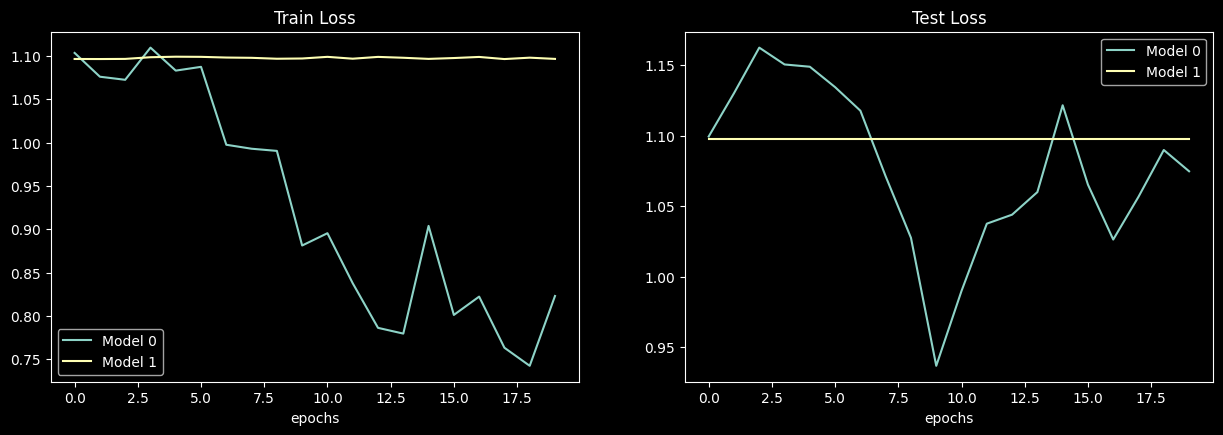

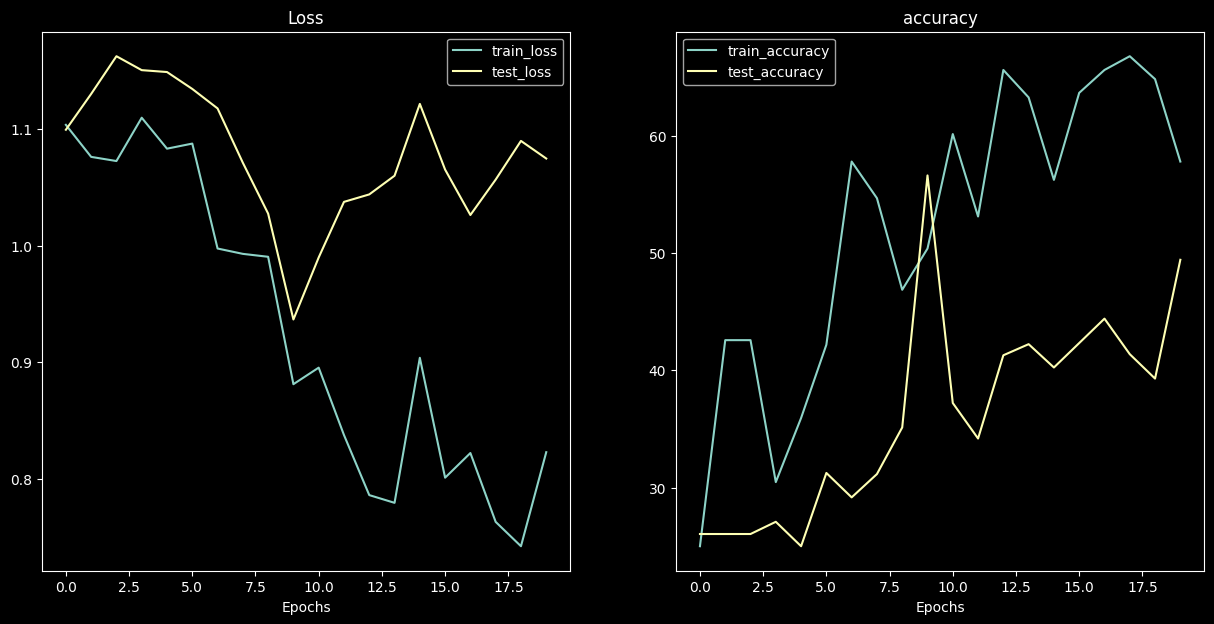

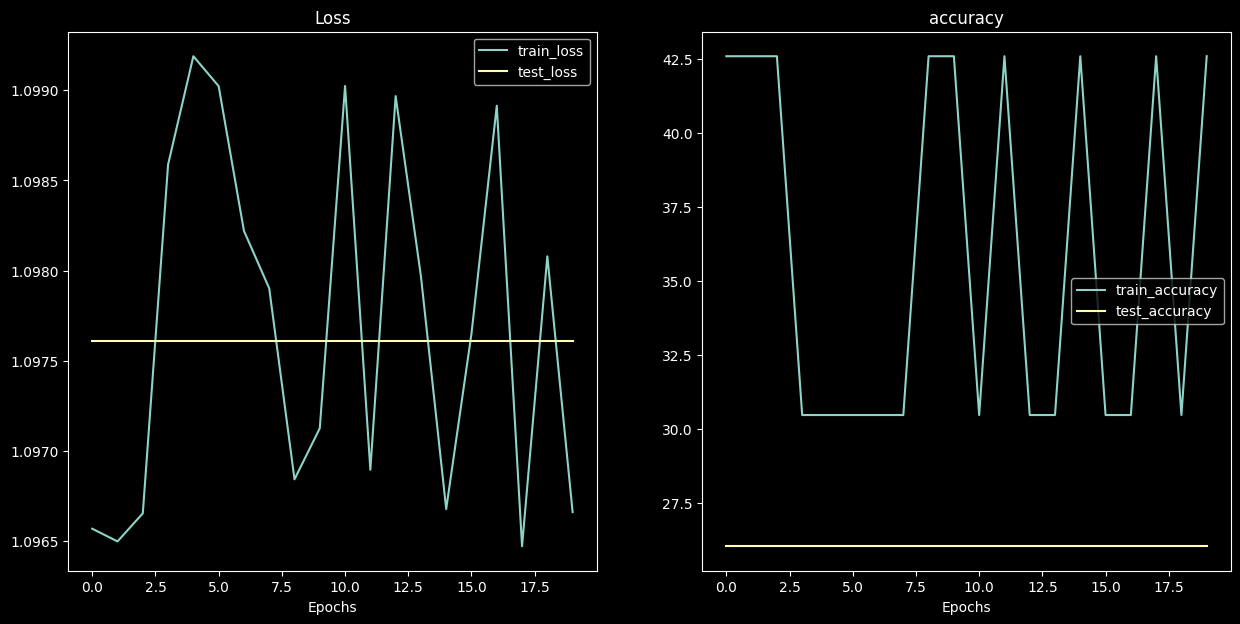

In [93]:
# setup plots
model4_df = pd.DataFrame(model4_results)
model5_df = pd.DataFrame(model5_results)
epochs = range(len(model4_df))

plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
plt.plot(epochs,model4_df["train_loss"], label= "Model 0")
plt.plot(epochs,model5_df["train_loss"], label= "Model 1")
plt.title("Train Loss")
plt.xlabel("epochs")
plt.legend()

plt.subplot(2,2,2)
plt.plot(epochs,model4_df["test_loss"], label= "Model 0")
plt.plot(epochs,model5_df["test_loss"], label= "Model 1")
plt.title("Test Loss")
plt.xlabel("epochs")
plt.legend()

# Check if overfitting/underfitting
plot_loss_curves(model4_results)
plot_loss_curves(model5_results)
